In [1]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import re, collections
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from spellchecker import SpellChecker
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Getting the data
dataframe = pd.read_csv('training_set_rel3.csv', encoding = 'latin-1')
dataframe.describe()

,essay_id,essay_set,rater1_domain1,rater2_domain1,domain1_score
count,12978.000000,12978.000000,12977.000000,12977.000000,12977.000000
mean,10295.432809,4.179458,4.126840,4.137089,6.799723
std,6308.588616,2.136749,4.212537,4.264320,8.970558
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,4439.250000,2.000000,2.000000,2.000000,2.000000
50%,10045.500000,4.000000,3.000000,3.000000,3.000000
75%,15680.750000,6.000000,4.000000,4.000000,8.000000
max,21633.000000,8.000000,30.000000,30.000000,60.000000


In [3]:
dataframe.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0


In [4]:
def convert_scores(scores):
    def mapping(x):
        if x < np.percentile(scores, 25):
            return 0
        elif x < np.percentile(scores, 75):
            return 1
        else:
            return 2
    return scores.apply(mapping)

In [5]:
def select_set(dataframe,setNumber):
    if setNumber == 9:
        dataframe2 = dataframe[dataframe.essay_set == 1]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x * 3)/scores.max())
        scores = convert_scores(scores)
        for i in range(1,9):
            dataframe2 = dataframe[dataframe.essay_set == i]
            texts = texts.append(dataframe2['essay'])
            s = dataframe2['domain1_score']
            s = s.apply(lambda x: (x*3)/s.max())
            s = convert_scores(s)
            scores = scores.append(s)
    else:
        dataframe2 = dataframe[dataframe.essay_set == setNumber]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x * 3)/scores.max())
        scores = convert_scores(scores)
    return texts, scores

In [6]:
#Average word length for a text
def avg_word_len(text):
    clean_essay = re.sub(r'\W', ' ', text)
    words = nltk.word_tokenize(clean_essay)
    total = 0
    for word in words:
        total = total + len(word)
    average = total / len(words)
    
    return average

# Word count in a given text
def word_count(text):
    clean_essay = re.sub(r'\W', ' ', text)
    return len(nltk.word_tokenize(clean_essay))

# Char count in a given text
def char_count(text):
    return len(re.sub(r'\s', '', str(text).lower()))

# Sentence count in a given text
def sent_count(text):
    return len(nltk.sent_tokenize(text))

# Tokenization of texts to sentences
def sent_tokenize(text):
    stripped_essay = text.strip()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
            tokens = nltk.word_tokenize(clean_sentence)
            tokenized_sentences.append(tokens)
    return tokenized_sentences


# lemma, noun, adjective, verb, adverb count for a given text
def count_lemmas(text):
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0   
    lemmas = []
    lemmatizer = WordNetLemmatizer()
    tokenized_sentences = sent_tokenize(text)
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
            
            if pos_tag.startswith('N'): 
                noun_count += 1
                pos = wordnet.NOUN
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                adj_count += 1
                pos = wordnet.ADJ
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                verb_count += 1
                pos = wordnet.VERB
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                adv_count += 1
                pos = wordnet.ADV
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
    
    lemma_count = len(set(lemmas))
    
    return noun_count, adj_count, verb_count, adv_count, lemma_count

In [7]:
def token_word(text):
    text = "".join([ch.lower() for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return tokens

In [8]:
# find those words that may be misspelled
def misspell_count(text):
    spell = SpellChecker()
    misspelled = spell.unknown(token_word(text))
    return len(misspelled)

In [9]:
def create_features(texts):
    data = pd.DataFrame(columns=('Average_Word_Length','Sentence_Count','Word_Count',
                                'Character_Count', 'Noun_Count','Adjective_Count',
                                'Verb_Count', 'Adverb_Count', 'Lemma_Count' , 'Misspell_Count'
                                 ))

    data['Average_Word_Length'] = texts.apply(avg_word_len)
    data['Sentence_Count'] = texts.apply(sent_count)
    data['Word_Count'] = texts.apply(word_count)
    data['Character_Count'] = texts.apply(char_count)
    temp=texts.apply(count_lemmas)
    noun_count,adj_count,verb_count,adverb_count,lemma_count = zip(*temp)
    data['Noun_Count'] = noun_count
    data['Adjective_Count'] = adj_count
    data['Verb_Count'] = verb_count
    data['Adverb_Count'] = adverb_count
    data['Lemma_Count'] = lemma_count
    data['Misspell_Count'] = texts.apply(misspell_count)
    return data

In [10]:
#Create features from the texts, clean non-graded essays and train-test split the data
def data_prepare(texts,scores):
    data = create_features(texts)
    data.describe()
    t1 = np.where(np.asanyarray(np.isnan(scores)))
    scores = scores.drop(scores.index[t1])
    data = data.drop(scores.index[t1])

    X_train, X_test, y_train, y_test = train_test_split(data, scores, test_size = 0.3)

    return X_train, X_test, y_train, y_test, data

In [11]:
texts, scores = select_set(dataframe,1)
X_train, X_test, y_train, y_test, data = data_prepare(texts,scores)

In [12]:
#Training for Linear Regression Algorithm
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The mean-squared error
mse = mean_squared_error(y_test, y_pred)
mse_per = 100*mse/3
print("Mean squared error: {}".format(mse))
print("Mean squared error in percentage: {}".format(mse_per))
# The variance score
print('Variance score: {}'.format(regr.score(X_test, y_test)))
# The kappa score
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

Mean squared error: 0.17316543419861366
Mean squared error in percentage: 5.772181139953788
Variance score: 0.5893121289669208
Cohen's kappa score: 0.56


Mean squared error: 0.22276017304714152
Mean squared error in percentage: 7.425339101571384
Variance score: 0.4716907468105821
Cohen's kappa score: 0.58


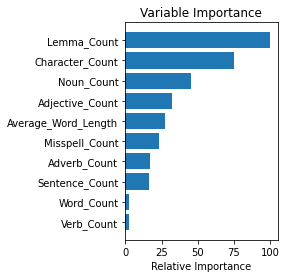

In [13]:
#Training for AdaBoost Regression Algorithm
regr = AdaBoostRegressor()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
#The mean squared error
mse = mean_squared_error(y_test, y_pred)
mse_per = 100*mse/3
print("Mean squared error: {}".format(mse))
print("Mean squared error in percentage: {}".format(mse_per))
#explained variance score
print('Variance score: {}'.format(regr.score(X_test, y_test)))
#Kappa score
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

feature_importance = regr.feature_importances_

#Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_names = list(('Average_Word_Length','Sentence_Count','Word_Count',
                            'Character_Count', 'Noun_Count','Adjective_Count',
                            'Verb_Count', 'Adverb_Count', 'Lemma_Count' ,'Misspell_Count'
                     ))
feature_names = np.asarray(feature_names)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()